In [1]:
"""
% Before trying to construct hybrid images, it is suggested that you
% implement my_imfilter.m and then debug it using proj1_test_filtering.m

% Debugging tip: You can split your MATLAB code into cells using "%%"
% comments. The cell containing the cursor has a light yellow background,
% and you can press Ctrl+Enter to run just the code in that cell. This is
% useful when projects get more complex and slow to rerun from scratch
"""

import matplotlib.pyplot as plt
import os
import cv2
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean


In [2]:
def my_imfilter(image,filter):  #which will work identically to the function below
#    output = imfilter(image, filter) #replace your code here
#    output = scipy.ndimage.correlate(image, filter, mode='constant').transpose()
    filter = np.flipud(np.fliplr(filter))
    
    pad_len = filter.shape[0]
    pad_width = filter.shape[1]
    
    img_len = image.shape[0]
    img_width = image.shape[1]
    
    ch = len(image[0][0])
    
    output = np.zeros_like(image)
    image_padded = np.zeros((img_len+pad_len-1, img_width+pad_width-1, image.shape[2]))
    image_padded[int((pad_len-1)/2):img_len+int((pad_len-1)/2), int((pad_width-1)/2):img_width+int((pad_width-1)/2)] = image
    
    for k in range(len(image[0][0])):    
        for x in range(image.shape[1]):
            for y in range(image.shape[0]):
                #output[y,x,k] = (filter*image_padded[y:y+filter.shape[0], x:x+filter.shape[1],k]).sum()
                output[y,x,k] = np.multiply(filter, image_padded[y:y+filter.shape[0], x:x+filter.shape[1],k]).sum()
    output = np.clip(output, 0, 1)
    return output        

In [3]:
def matlab_style_gauss2D(shape,sigma):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    #print(h.shape,"in gaussian")
    return h

In [4]:
def  vis_hybrid_image(hybrid_image):

    """
    %visualize a hybrid image by progressively downsampling the image and
    %concatenating all of the images together.
    """
    scales = 5#how many downsampled versions to create
    padding = 5 #how many pixels to pad.

    original_height = hybrid_image.shape[0]
    num_colors = hybrid_image.shape[2] #counting how many color channels the input has
    output = hybrid_image
    cur_image = hybrid_image

    for i in range(2,scales+1):
      # add padding
      #output = cat(2, output, np.ones(original_height, padding, num_colors)) #implement the correct command here
        output = np.concatenate((output, np.ones((original_height, padding, num_colors))), axis=1)  
    # dowsample image
        cur_image = resize(cur_image,(cur_image.shape[0] // 2, cur_image.shape[1] // 2), \
                    anti_aliasing=True)
      # pad the top and append to the output
        tmp = np.concatenate((np.ones((original_height - cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)

        output =  np.concatenate((output, tmp), axis=1)    
  
  
    return(output)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


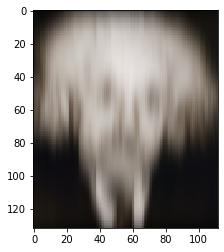

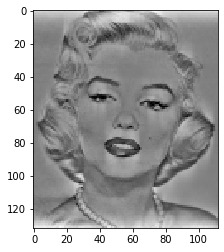

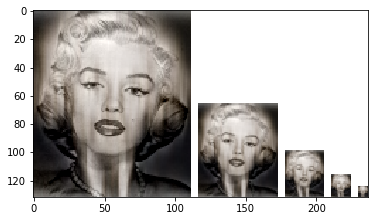

In [5]:

#%% close all figures
plt.close('all') # closes all figures

#%% Setup
#% read images and convert to floating point format
image1 = mpimg.imread('../data/einstein.bmp')
image1 = resize(image1, (image1.shape[0] // 2, image1.shape[1] // 2), \
                    anti_aliasing=True)#resizing to speed up testing


image2 = mpimg.imread('../data/marilyn.bmp')
image2 = resize(image2, (image2.shape[0] // 2, image2.shape[1] // 2), \
                    anti_aliasing=True)#resizing to speed up testing


# plt.figure(1)
# plt.imshow(image1)

# plt.figure(2)
# plt.imshow(image2)
"""
% Several additional test cases are provided for you, but feel free to make
% your own (you'll need to align the images in a photo editor such as
% Photoshop). The hybrid images will differ depending on which image you
% assign as image1 (which will provide the low frequencies) and which image
% you asign as image2 (which will provide the high frequencies)
"""

""" %% Filtering and Hybrid Image construction """
cutoff_frequency = 7  

"""This is the standard deviation, in pixels, of the 
% Gaussian blur that will remove the high frequencies from one image and 
% remove the low frequencies from another image (by subtracting a blurred
% version from the original version). You will want to tune this for every
% image pair to get the best results. """

filter = matlab_style_gauss2D((cutoff_frequency*4+1,1),cutoff_frequency)#insert values from fspecial('Gaussian', cutoff_frequency*4+1, cutoff_frequency) here
#print(filter)
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% YOUR CODE BELOW. Use my_imfilter to create 'low_frequencies' and
% 'high_frequencies' and then combine them to create 'hybrid_image'
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Remove the high frequencies from image1 by blurring it. The amount of
% blur that works best will vary with different image pairs
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
"""

low_frequencies = my_imfilter(image1, filter)
# plt.figure(3)
# #"""11"""
# plt.imshow(low_frequencies)

# high_freq = image1-low_frequencies
# plt.figure(4)
# plt.imshow(high_freq)

"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Remove the low frequencies from image2. The easiest way to do this is to
% subtract a blurred version of image2 from the original version of image2.
% This will give you an image centered at zero with negative values.
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""
#filter2 = matlab_style_gauss2D((100,1),10000000)
low_2 = my_imfilter(image2, filter)
high_frequencies = image2-low_2
# plt.figure(4)
# plt.imshow(high_frequencies)

"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Combine the high frequencies and low frequencies
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""
hybrid_image = np.clip(low_frequencies + high_frequencies, 0, 1) 

#%% Visualize and save outputs

plt.figure(1)
plt.imshow(low_frequencies)
plt.figure(4)
plt.imshow(high_frequencies + 0.5);
vis = vis_hybrid_image(hybrid_image) #see function script vis_hybrid_image.py
plt.figure(3)
plt.imshow(vis)
mpimg.imsave('Results/low_frequencies.jpg',low_frequencies)
mpimg.imsave('Results/high_frequencies.jpg',np.clip(high_frequencies + 0.5, 0, 1))
mpimg.imsave('Results/hybrid_image.jpg',hybrid_image)
mpimg.imsave('Results/hybrid_image_scales.jpg',vis)